## Run Ad-Hoc Data Bias Analysis

### Run Bias Analysis In The Notebook using smclarify

In [1]:
!pip install -q smclarify==0.1

In [2]:
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns

## Read Dataset From S3.

In [3]:
%store -r bias_data_s3_uri

In [4]:
print(bias_data_s3_uri)

s3://sagemaker-us-east-1-254716743917/bias-detection-1650234746/integrated_data.csv


In [5]:
%store -r balanced_bias_data_s3_uri

In [6]:
print(balanced_bias_data_s3_uri)

s3://sagemaker-us-east-1-254716743917/bias-detection-1650234746/integrated_data_balanced.csv


In [7]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-254716743917/bias-detection-1650234746/integrated_data.csv to data-clarify/integrated_data.csv


In [8]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-254716743917/bias-detection-1650234746/integrated_data_balanced.csv to data-clarify/integrated_data_balanced.csv


## Analyze Unbalanced Data

In [9]:
df = pd.read_csv("./data-clarify/integrated_data.csv")
df.shape

(1384617, 11)

<AxesSubplot:xlabel='reordered', ylabel='count'>

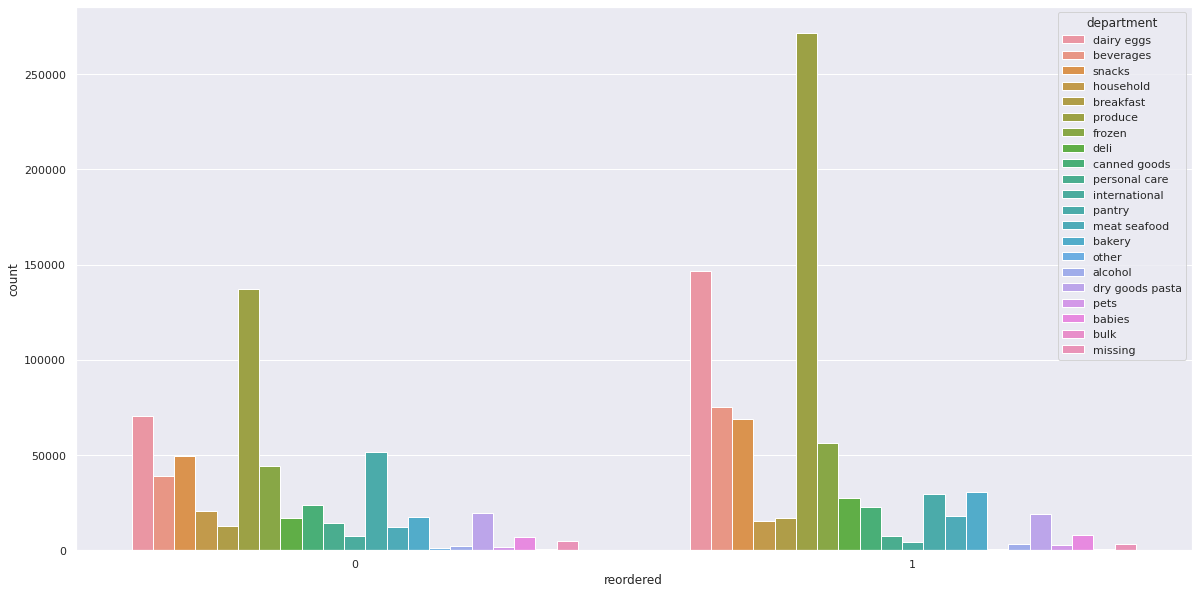

In [10]:
sns.set(rc={"figure.figsize": (20.0, 10.0)})
sns.countplot(data=df, x="reordered", hue="department")

## Calculate Bias Metrics on Unbalanced Data

### Define

     Facet Column (= department),
     Label Column (= reordered),
     Positive Label Value (=1)



In [11]:
facet_column = report.FacetColumn(name="department")

label_column = report.LabelColumn(
    name="reordered", 
    data=df["reordered"], 
    positive_label_values=[1]
)

### Run SageMaker Clarify Bias Report

In [12]:
report.bias_report(
    df=df, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

[{'value_or_threshold': 'dairy eggs',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.6864822546595918},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': -0.0905688494355229},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0044054990242861705},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.017954482978937494},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0905688494355229},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.1280836952002433},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.09056884943552287}]},
 {'value_or_threshold': 'beverages',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.8352670810772943},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions

## Balance the data

In [13]:
df_grouped_by = df.groupby(["department", "reordered"])[["department", "reordered"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

(24066, 2)

<AxesSubplot:xlabel='reordered', ylabel='count'>

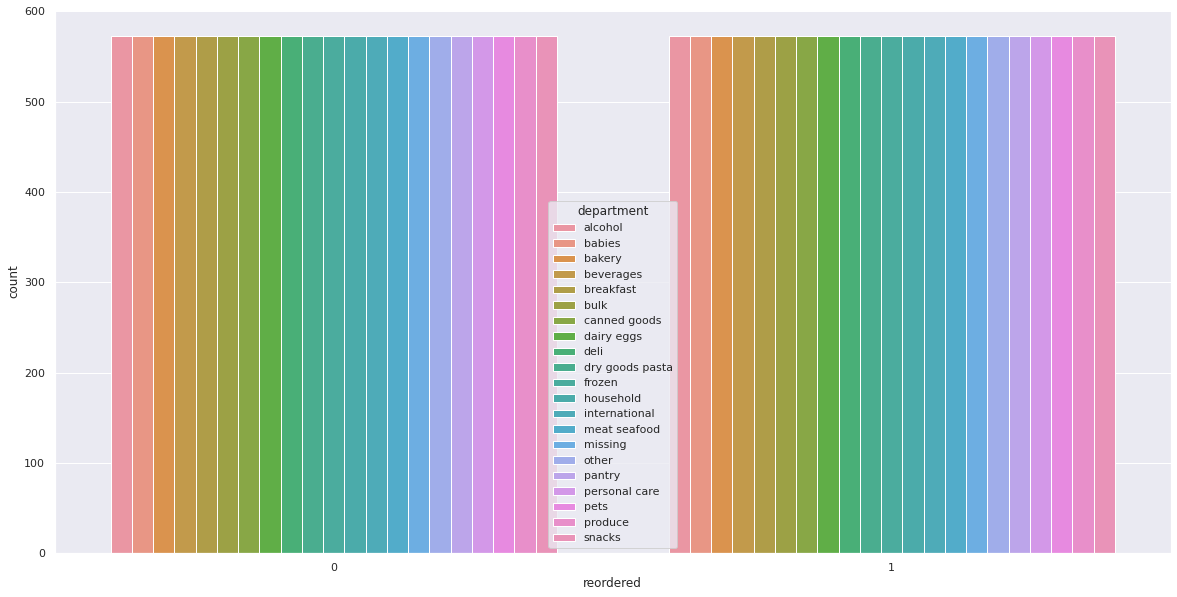

In [14]:
import seaborn as sns
sns.set(rc={"figure.figsize": (20.0, 10.0)})
sns.countplot(data=df_balanced, x="reordered", hue="department")

## Calculate Bias Metrics on Balanced Data
### Define

    Facet Column (= department),
    Label Column (= reordered),
    Positive Label Value (= 1)



In [15]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="department")

label_column = report.LabelColumn(
    name="reordered", 
    data=df_balanced["reordered"], 
    positive_label_values=[1]
)

## Run SageMaker Clarify Bias Report

In [16]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

[{'value_or_threshold': 'alcohol',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.9047619047619048},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.0},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.0},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.0}]},
 {'value_or_threshold': 'babies',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.9047619047619048},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (